In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

Calibrating the camera

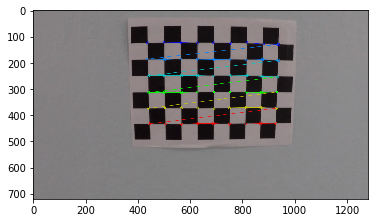

In [2]:
%matplotlib inline

img = cv2.imread('./camera_cal/calibration18.jpg')
orig_img = np.copy(img)
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

objpoints = []
imgpoints = []

# From "Calibrating your camera" section
objp = np.zeros((ny*nx,3), np.float32)
objp [:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    imgpoints.append(corners)
    objpoints.append(objp)
    plt.imshow(img)

[[ 977.31165196    0.          617.74829907]
 [   0.          884.40013628  671.68615741]
 [   0.            0.            1.        ]]
[[-0.22276576  0.12507811 -0.06194384  0.00408661 -0.16227024]]


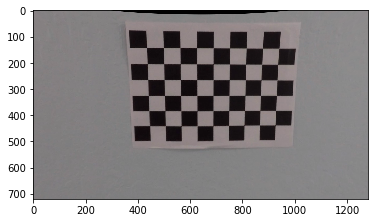

In [3]:
# Learn the camera distortion characteristics
# Function comes from "Correcting for Distortion" unit in project's lesson
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:-1], None, None)
    #undist = np.copy(img)  # Delete this line
    return mtx, dist

mtx, dist = cal_undistort(orig_img, objpoints, imgpoints)

# Use the OpenCV undistort() function to remove distortion
undist = cv2.undistort(orig_img, mtx, dist, None, mtx)

print (mtx)
print (dist)
plt.imshow(undist)


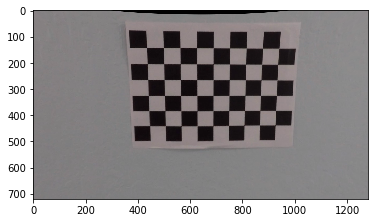

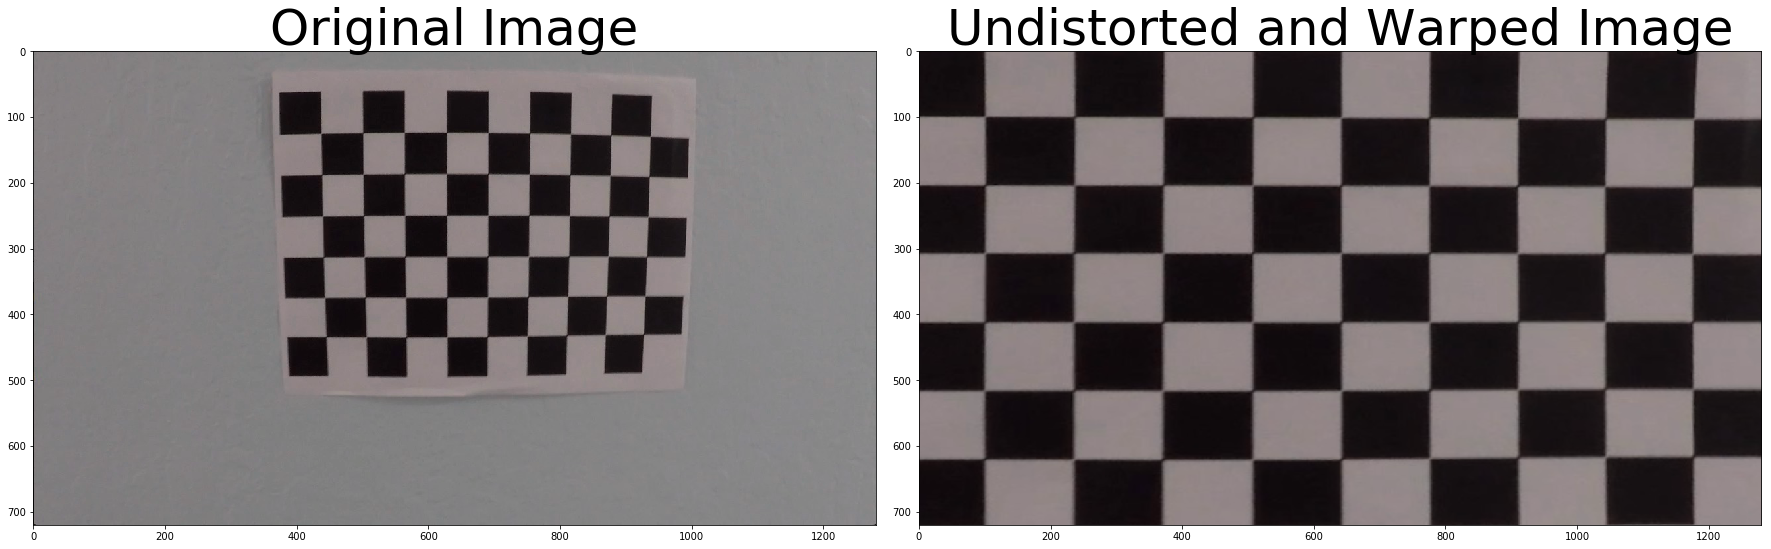

In [7]:
# Function comes from "Undistort and Transform Perspective" unit in the project's lesson
def corners_unwarp(img, nx, ny, mtx, dist):  
    checkerboard_img = np.copy(img)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    plt.imshow(img)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        #cv2.drawChessboardCorners(checkerboard_img, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M


top_down, perspective_M = corners_unwarp(undist, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [ ]:
%matplotlib inline

# Read in an image
image = mpimg.imread('./test_images/straight_lines1.jpg')

f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)